Downloaded data from: https://data.stanford.edu/congress_text, hein-bound.zip
- Covers the 43rd to 111th Congresses (1873–2011)
With this code I'm merging the speeches, speaker map, and speech description files to get more complete picture. 

Had some issues parsing and decoding: The UnicodeDecodeError you're seeing happens because the Congressional Record files were digitized using OCR (Optical Character Recognition), which often introduces special characters or symbols that aren't valid in standard UTF-8 encoding. Specifically, byte 0x95 is often a "bullet point" or "dash" in Windows-specific encodings like ISO-8859-1 or Latin-1.

In [ ]:
import pandas as pd
import os

# Your exact session number
session = '111' 
# The directory where your files are stored
data_dir = '/Users/mj/Desktop/Misc/VSCodeStuff/legNLP/raw' 

def load_congress_data(session_num, folder):
    # Construct the paths using os.path.join for cross-platform compatibility
    speeches_path = os.path.join(folder, f'speeches_{session_num}.txt')
    descr_path = os.path.join(folder, f'descr_{session_num}.txt')
    speaker_map_path = os.path.join(folder, f'{session_num}_SpeakerMap.txt')

    # Load with the updated paths
# Change your read_csv lines to use ISO-8859-1
    # skips problematic lines and prints a warning for each one
    speeches = pd.read_csv(speeches_path, sep='|', encoding='ISO-8859-1', on_bad_lines='warn')
    descr = pd.read_csv(descr_path, sep='|', encoding='ISO-8859-1')
    speaker_map = pd.read_csv(speaker_map_path, sep='|', encoding='ISO-8859-1')

    # Merge logic remains the same
    merged_df = pd.merge(speeches, descr, on='speech_id', how='left')
    final_df = pd.merge(merged_df, speaker_map, on='speech_id', how='left')

    return final_df

# Run the fixed function
df = load_congress_data(session, data_dir)
print(f"Loaded {len(df)} speeches from session {session}.")

# Save the combined results to a single file
df.to_csv(f'congress_{session}_master.csv', index=False)
print(f"File saved: congress_{session}_master.csv")

/var/folders/fg/4ss0bm_12m7bty36466t8h6h0000gp/T/ipykernel_23485/3935276546.py:18: ParserWarning: Skipping line 55163: expected 2 fields, saw 3

  speeches = pd.read_csv(speeches_path, sep='|', encoding='ISO-8859-1', on_bad_lines='warn')


Loaded 179267 speeches from session 111.
File saved: congress_111_master.csv


Here we will do the first batch of denoising

In [19]:
import pandas as pd
from collections import Counter
import re

# 1. Load your master CSV
df = pd.read_csv('/Users/mj/Desktop/Misc/VSCodeStuff/legNLP/processed/congress_045_master.csv')

# 2. Define Congressional Stopwords from Table 13 of the Codebook
# These are the procedural words that dilute your topic model
congress_stopwords = {
    'absent', 'adjourn', 'ask', 'can', 'chairman', 'committee', 'con', 'democrat', 
    'etc', 'gentleladies', 'gentlelady', 'gentleman', 'gentlemen', 'gentlewoman', 
    'gentlewomen', 'hereabout', 'hereafter', 'hereat', 'hereby', 'herein', 
    'hereinafter', 'hereinbefore', 'hereinto', 'hereof', 'hereon', 'hereto', 
    'heretofore', 'hereunder', 'hereunto', 'hereupon', 'herewith', 'month', 'mr', 
    'mrs', 'nai', 'nay', 'none', 'now', 'part', 'per', 'pro', 'republican', 'say', 
    'senator', 'shall', 'sir', 'speak', 'speaker', 'tell', 'thank', 'thereabout', 
    'thereafter', 'thereagainst', 'thereat', 'therebefore', 'therebeforn', 
    'thereby', 'therefor', 'therefore', 'therefrom', 'therein', 'thereinafter', 
    'thereof', 'thereon', 'thereto', 'theretofore', 'thereunder', 'thereunto', 
    'thereupon', 'therewith', 'therewithal', 'today', 'whereabouts', 'whereafter', 
    'whereas', 'whereat', 'whereby', 'wherefore', 'wherefrom', 'wherein', 
    'whereinto', 'whereof', 'whereon', 'whereto', 'whereunder', 'whereupon', 
    'wherever', 'wherewith', 'wherewithal', 'will', 'yea', 'yes', 'yield'
}

# Standard English stopwords to add to the list
standard_stopwords = {'the', 'to', 'of', 'and', 'a', 'in', 'that', 'is', 'it', 'for', 'be', 'on', 'with', 'as', 'this', 'was', 'by', 'not', 'i', 'from', 'are', 'which', 'he', 'his', 'at', 'has', 'but', 'or', 'an', 'they', 'their', 'we', 'so', 'been', 'there', 'if', 'all', 'any', 'my', 'me', 'no', 'upon', 'one', 'more', 'would', 'could', 'should', 'than', 'them', 'who', 'said', 'him', 'what'}

# Combine them
all_stopwords = congress_stopwords.union(standard_stopwords)

def get_policy_words(texts, n=10):
    all_words = []
    for text in texts:
        # Tokenize: lowercase and keep only alphanumeric
        words = re.findall(r'\b\w+\b', str(text).lower())
        # Filter: remove words in stoplist and words shorter than 3 letters
        all_words.extend([w for w in words if w not in all_stopwords and len(w) > 2])
    return Counter(all_words).most_common(n)

# 3. Analyze by Party
# Filter out rows without a party and stick to the two main ones
df_filtered = df.dropna(subset=['party'])
df_filtered = df_filtered[df_filtered['party'].isin(['D', 'R'])]

print("--- Cleaned Top Words: Democrats (D) ---")
print(get_policy_words(df_filtered[df_filtered['party'] == 'D']['speech']))

print("\n--- Cleaned Top Words: Republicans (R) ---")
print(get_policy_words(df_filtered[df_filtered['party'] == 'R']['speech']))

--- Cleaned Top Words: Democrats (D) ---
[('have', 31601), ('bill', 21013), ('house', 12268), ('states', 11714), ('were', 10835), ('these', 10700), ('question', 10395), ('its', 10108), ('government', 10065), ('had', 9950)]

--- Cleaned Top Words: Republicans (R) ---
[('have', 32319), ('bill', 22403), ('senate', 10941), ('time', 10676), ('had', 10595), ('these', 10412), ('house', 10378), ('states', 10258), ('other', 10253), ('were', 10217)]


Next batch of denoising

In [20]:
# 2. Expanded Stopword List (Standard + Congressional Table 13)
# Including those pesky "have", "were", "had" words
stop_list = {
    'have', 'had', 'were', 'was', 'been', 'being', 'has', 'did', 'does', 'their', 'them',
    'this', 'that', 'these', 'those', 'which', 'who', 'whom', 'whose', 'what', 'when',
    'where', 'why', 'how', 'bill', 'house', 'senate', 'senator', 'states', 'government',
    'committee', 'gentleman', 'gentlemen', 'mr', 'mrs', 'speaker', 'shall', 'should',
    'would', 'could', 'may', 'might', 'must', 'can', 'will', 'very', 'more', 'most',
    'other', 'some', 'such', 'than', 'then', 'there', 'here', 'any', 'all', 'every',
    'each', 'now', 'today', 'question', 'time', 'its', 'said', 'say', 'saying', 'tell',
    'asked', 'ordered', 'provide', 'under', 'into', 'upon', 'after', 'before', 'member'
}

# Add the specific Stanford procedural words
stanford_procedural = {'adjourn', 'absent', 'nai', 'nay', 'yea', 'yes', 'yield', 'pro', 'con'}
final_stops = stop_list.union(stanford_procedural)

def get_policy_content(texts, n=15):
    all_words = []
    for text in texts:
        words = re.findall(r'\b\w+\b', str(text).lower())
        # Filter for length > 3 to remove "act", "law", etc. if you want even deeper cleaning
        all_words.extend([w for w in words if w not in final_stops and len(w) > 3])
    return Counter(all_words).most_common(n)

# 3. Partisan Comparison
df_clean = df_filtered.dropna(subset=['party'])
df_clean = df_clean[df_clean['party'].isin(['D', 'R'])]

print("--- 45th Congress Policy Keywords (D) ---")
print(get_policy_content(df_clean[df_clean['party'] == 'D']['speech']))

print("\n--- 45th Congress Policy Keywords (R) ---")
print(get_policy_content(df_clean[df_clean['party'] == 'R']['speech']))

--- 45th Congress Policy Keywords (D) ---
[('from', 34509), ('with', 21770), ('they', 18216), ('state', 9242), ('made', 9239), ('amendment', 9076), ('united', 8145), ('congress', 7811), ('country', 7604), ('people', 7293), ('vote', 7180), ('order', 6586), ('make', 6536), ('only', 6430), ('great', 5482)]

--- 45th Congress Policy Keywords (R) ---
[('from', 35382), ('with', 21650), ('they', 18452), ('amendment', 9875), ('made', 8897), ('state', 8335), ('united', 7767), ('vote', 7106), ('think', 7097), ('make', 6994), ('order', 6984), ('only', 6575), ('congress', 6565), ('country', 6093), ('great', 5389)]


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Filter for the main two parties and drop empty speeches
df_analysis = df_clean.dropna(subset=['party', 'speech'])
df_analysis = df_analysis[df_analysis['party'].isin(['D', 'R'])]

# TF-IDF penalizes common words like "from", "with", and "the"
# max_df=0.7 means "ignore words that appear in more than 70% of speeches"
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, min_df=5)

def get_top_tfidf(party_label, n=10):
    subset = df_analysis[df_analysis['party'] == party_label]['speech']
    matrix = vectorizer.fit_transform(subset)
    scores = zip(vectorizer.get_feature_names_out(), matrix.sum(axis=0).tolist()[0])
    return sorted(scores, key=lambda x: x[1], reverse=True)[:n]

print("--- Democrats Distinctive Terms ---")
print(get_top_tfidf('D'))

print("\n--- Republicans Distinctive Terms ---")
print(get_top_tfidf('R'))

--- Democrats Distinctive Terms ---
[('gentleman', 1561.9200345692982), ('committee', 1407.9713289308963), ('mr', 1211.6384114387579), ('question', 1200.2717240201325), ('amendment', 1173.805772589443), ('order', 1136.4891936388578), ('ask', 1123.917786736062), ('house', 1104.2608788022162), ('senator', 1072.1175613390608), ('vote', 977.971667451747)]

--- Republicans Distinctive Terms ---
[('senator', 1636.0179579332173), ('committee', 1340.7154162724123), ('amendment', 1294.0397602075489), ('gentleman', 1272.5877854715557), ('mr', 1237.454602020054), ('order', 1187.5558750583427), ('question', 1141.715598057431), ('ask', 1106.0203392102703), ('senate', 996.2086820821689), ('vote', 967.9417415485527)]


While TF-IDF effectively downweighted universal English stopwords, the results are still dominated by the 'Parliamentary Skeleton'—formal titles and procedural terms required by the rules of the House and Senate. To uncover the substantive policy debates, I must implement the domain-specific stopword list identified in the project codebook.

In [22]:
# 1. Expand stop_words with the noise we just found
procedural_noise = {
    'gentleman', 'committee', 'mr', 'question', 'amendment', 'order', 
    'ask', 'house', 'senator', 'vote', 'senate', 'speaker', 'chairman',
    'shall', 'said', 'will', 'say', 'make', 'time', 'president'
}
final_stops = list(vectorizer.get_stop_words()) + list(procedural_noise)

# 2. Switch to Bigrams (ngram_range=(2,2))
# This looks for pairs of words which carry much more policy meaning
vectorizer_2 = TfidfVectorizer(
    stop_words=final_stops, 
    max_df=0.5, 
    min_df=10, 
    ngram_range=(2, 2)
)

def get_top_policy_bigrams(party_label, n=10):
    subset = df_analysis[df_analysis['party'] == party_label]['speech']
    matrix = vectorizer_2.fit_transform(subset)
    scores = zip(vectorizer_2.get_feature_names_out(), matrix.sum(axis=0).tolist()[0])
    return sorted(scores, key=lambda x: x[1], reverse=True)[:n]

print("--- Democrats Policy Phrases (Bigrams) ---")
print(get_top_policy_bigrams('D'))

print("\n--- Republicans Policy Phrases (Bigrams) ---")
print(get_top_policy_bigrams('R'))

--- Democrats Policy Phrases (Bigrams) ---
[('united states', 618.0184915432792), ('new york', 465.7868349096671), ('yeas nays', 411.5524929220335), ('unanimous consent', 406.00753043053845), ('morning hour', 238.0192376694616), ('paired colleague', 177.26130610836853), ('000 000', 162.30561238724235), ('yes sir', 154.26537427108727), ('joint resolution', 152.08050326612903), ('district columbia', 151.83289919105508)]

--- Republicans Policy Phrases (Bigrams) ---
[('united states', 708.027555390303), ('new york', 492.3696536314236), ('yeas nays', 477.95576114708535), ('unanimous consent', 385.4926702249468), ('proceed consideration', 205.41993486102646), ('morning hour', 195.2364569602535), ('000 000', 180.77410564179996), ('paired colleague', 169.26242797546496), ('north carolina', 168.69616562793894), ('west virginia', 166.7022862997329)]


In [23]:
# 1. Add the bigram noise you just discovered
boilerplate_bigrams = {
    'united states', 'yeas nays', 'unanimous consent', 'morning hour', 
    'paired colleague', 'yes sir', 'joint resolution', 'district columbia',
    'proceed consideration', '000 000', 'ordered lie', 'table motion',
    'pending bill', 'ordered printed', 'previous question', 'referred committee'
}

# 2. Add State Names (as recommended by the codebook)
states = {
    'new york', 'north carolina', 'west virginia', 'rhode island', 'south carolina',
    'new jersey', 'new hampshire', 'mississippi', 'louisiana', 'pennsylvania',
    'massachusetts', 'virginia', 'maryland', 'ohio', 'illinois', 'kentucky'
}

# Combine all stops
final_bigram_stops = list(vectorizer_2.get_stop_words()) + list(boilerplate_bigrams) + list(states)

# 3. Final TF-IDF Run
vectorizer_3 = TfidfVectorizer(
    stop_words=final_bigram_stops,
    max_df=0.4, # Tighten this to catch more common boilerplate
    min_df=5,
    ngram_range=(2, 2)
)

def get_final_policy_bigrams(party_label, n=12):
    subset = df_analysis[df_analysis['party'] == party_label]['speech']
    matrix = vectorizer_3.fit_transform(subset)
    scores = zip(vectorizer_3.get_feature_names_out(), matrix.sum(axis=0).tolist()[0])
    return sorted(scores, key=lambda x: x[1], reverse=True)[:n]

print("--- 45th Congress: Democrats Policy Signal ---")
print(get_final_policy_bigrams('D'))

print("\n--- 45th Congress: Republicans Policy Signal ---")
print(get_final_policy_bigrams('R'))

--- 45th Congress: Democrats Policy Signal ---


/Users/mj/Desktop/Misc/VSCodeStuff/.venv/lib/python3.14/site-packages/sklearn/feature_extraction/text.py:411: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['000', 'carolina', 'colleague', 'columbia', 'consent', 'consideration', 'district', 'hampshire', 'hour', 'island', 'jersey', 'joint', 'lie', 'morning', 'motion', 'nays', 'new', 'north', 'ordered', 'paired', 'pending', 'previous', 'printed', 'proceed', 'referred', 'resolution', 'rhode', 'sir', 'south', 'states', 'table', 'unanimous', 'united', 'west', 'yeas', 'yes', 'york'] not in stop_words.
  warnings.warn(


[('united states', 477.6142978070894), ('yeas nays', 381.8198798214549), ('new york', 364.8034507518951), ('unanimous consent', 328.0537921860268), ('morning hour', 195.82733108535675), ('paired colleague', 148.22846978146217), ('yield minutes', 138.91897816760905), ('yes sir', 136.27921532451646), ('000 000', 133.3323509129907), ('joint resolution', 124.33413486172819), ('present ay', 122.96689833379561), ('district columbia', 121.27385124811111)]

--- 45th Congress: Republicans Policy Signal ---
[('united states', 544.010072307988), ('yeas nays', 441.4664207041125), ('new york', 382.0954290281651), ('unanimous consent', 312.7055876779058), ('proceed consideration', 185.88410959202255), ('morning hour', 162.99858807296414), ('paired colleague', 156.51625989326052), ('000 000', 144.19170960150404), ('north carolina', 138.83084132401297), ('joint resolution', 129.9233956031125), ('district columbia', 125.79683786370155), ('called paired', 113.48536196242404)]


In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Load data
df = pd.read_csv('/Users/mj/Desktop/Misc/VSCodeStuff/legNLP/processed/congress_045_master.csv').dropna(subset=['party', 'speech'])
# Change this line in your notebook:
df_analysis = df[df['party'].isin(['D', 'R'])].copy()
# 2. Define the "Procedural Wall" - Specific phrases to delete entirely
boilerplate = [
    r'united states', r'yeas nays', r'unanimous consent', r'morning hour',
    r'paired colleague', r'yes sir', r'joint resolution', r'district columbia',
    r'proceed consideration', r'000 000', r'new york', r'north carolina',
    r'west virginia', r'rhode island', r'south carolina', r'new jersey',
    r'new hampshire', r'house representatives', r'presiding officer',
    r'previous question', r'referred committee', r'lie table', r'ordered printed'
]

def deep_clean(text):
    text = str(text).lower()
    # Remove the boilerplate phrases specifically
    for phrase in boilerplate:
        text = text.replace(phrase, '')
    # Remove any stray numbers and extra whitespace
    text = re.sub(r'\b\d+\b', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the deep clean to a copy of the data
df_analysis['clean_speech'] = df_analysis['speech'].apply(deep_clean)

# 3. Aggressive Unigram Stops (To resolve the sklearn warning)
# By removing these single words, the bigram vectorizer won't even see them
procedural_unigrams = [
    'gentleman', 'senator', 'speaker', 'chairman', 'committee', 'amendment',
    'house', 'senate', 'mr', 'president', 'order', 'question', 'yesterday',
    'tomorrow', 'bill', 'resolution', 'ask', 'yield', 'time', 'member'
]
final_stops = list(TfidfVectorizer(stop_words='english').get_stop_words()) + procedural_unigrams

# 4. Final Run: Focus on n-grams (2,3) to find specific policy names
vectorizer = TfidfVectorizer(
    stop_words=final_stops,
    max_df=0.3,   # Ignore phrases that appear in more than 30% of speeches
    min_df=10,    # Must appear at least 10 times
    ngram_range=(2, 2)
)

def get_real_policy(party_label):
    subset = df_analysis[df_analysis['clean_speech'] != '']
    subset = subset[subset['party'] == party_label]['clean_speech']
    matrix = vectorizer.fit_transform(subset)
    scores = zip(vectorizer.get_feature_names_out(), matrix.sum(axis=0).tolist()[0])
    return sorted(scores, key=lambda x: x[1], reverse=True)[:10]

print("--- 45th Congress: Actual Policy Signal (D) ---")
for phrase, score in get_real_policy('D'):
    print(f"{phrase}: {score:.2f}")

print("\n--- 45th Congress: Actual Policy Signal (R) ---")
for phrase, score in get_real_policy('R'):
    print(f"{phrase}: {score:.2f}")

--- 45th Congress: Actual Policy Signal (D) ---
yeas nays: 397.39
present vote: 261.41
vote ay: 237.45
make point: 205.14
desire say: 170.81
paired colleague: 159.51
district columbia: 151.97
yes sir: 147.46
ways means: 132.86
make motion: 128.87

--- 45th Congress: Actual Policy Signal (R) ---
yeas nays: 469.36
present vote: 242.74
vote ay: 222.21
proceed consideration: 208.82
make point: 205.84
district columbia: 159.72
desire say: 157.37
make motion: 154.46
paired colleague: 153.34
secretary treasury: 146.58
--- 45th Congress: Democrat Priorities ---
[('law', 2561.21718316294), ('appropriation', 1645.4598021283596), ('district', 945.2242248278366), ('war', 896.355258846454), ('army', 876.6876505239923), ('treasury', 860.6893942114654), ('court', 760.0773548059327), ('officer', 516.7039411251789), ('military', 479.61976192293173), ('pension', 441.8407918996829)]

--- 45th Congress: Republican Priorities ---
[('law', 2756.733552224779), ('appropriation', 1677.4665484607885), ('treasur

In [24]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Create a "Policy Dictionary" based on Table 11 of your codebook
# These are the specific topics the researchers found in the 45th Congress
policy_categories = {
    'Economy/Money': ['silver', 'gold', 'currency', 'coinage', 'bank', 'treasury', 'resumption'],
    'Defense/Army': ['army', 'military', 'officer', 'war', 'pension', 'defense', 'soldier'],
    'Infrastructure': ['railroad', 'bridge', 'river', 'harbor', 'public lands', 'post office'],
    'Budget/Tax': ['appropriation', 'revenue', 'tax', 'deficit', 'spending', 'internal revenue'],
    'Justice': ['court', 'judge', 'justice', 'district', 'law', 'civil rights']
}

# Flatten the dictionary into a single list of "Policy Signal" keywords
policy_keywords = [word for sublist in policy_categories.values() for word in sublist]

# 2. Clean the data and focus on D vs R
df_analysis = df[df['party'].isin(['D', 'R'])].copy()

# 3. Use TF-IDF but ONLY look for these Policy Keywords
# This "Vocabulary" parameter forces the model to ignore procedural noise
vectorizer = TfidfVectorizer(
    vocabulary=policy_keywords, 
    ngram_range=(1, 2),
    stop_words='english'
)

def get_party_priorities(party_label):
    subset = df_analysis[df_analysis['party'] == party_label]['speech']
    matrix = vectorizer.fit_transform(subset)
    scores = zip(vectorizer.get_feature_names_out(), matrix.sum(axis=0).tolist()[0])
    return sorted(scores, key=lambda x: x[1], reverse=True)[:10]

print("--- 45th Congress: Democrat Priorities ---")
print(get_party_priorities('D'))

print("\n--- 45th Congress: Republican Priorities ---")
print(get_party_priorities('R'))

--- 45th Congress: Democrat Priorities ---
[('law', 2561.21718316294), ('appropriation', 1645.4598021283596), ('district', 945.2242248278366), ('war', 896.355258846454), ('army', 876.6876505239923), ('treasury', 860.6893942114654), ('court', 760.0773548059327), ('officer', 516.7039411251789), ('military', 479.61976192293173), ('pension', 441.8407918996829)]

--- 45th Congress: Republican Priorities ---
[('law', 2756.733552224779), ('appropriation', 1677.4665484607885), ('treasury', 995.9013741709343), ('district', 966.9093718660002), ('war', 897.5629314481776), ('court', 859.0074632422351), ('army', 841.66810209965), ('pension', 762.3040123463554), ('officer', 601.4934260551172), ('railroad', 509.81800042298755)]


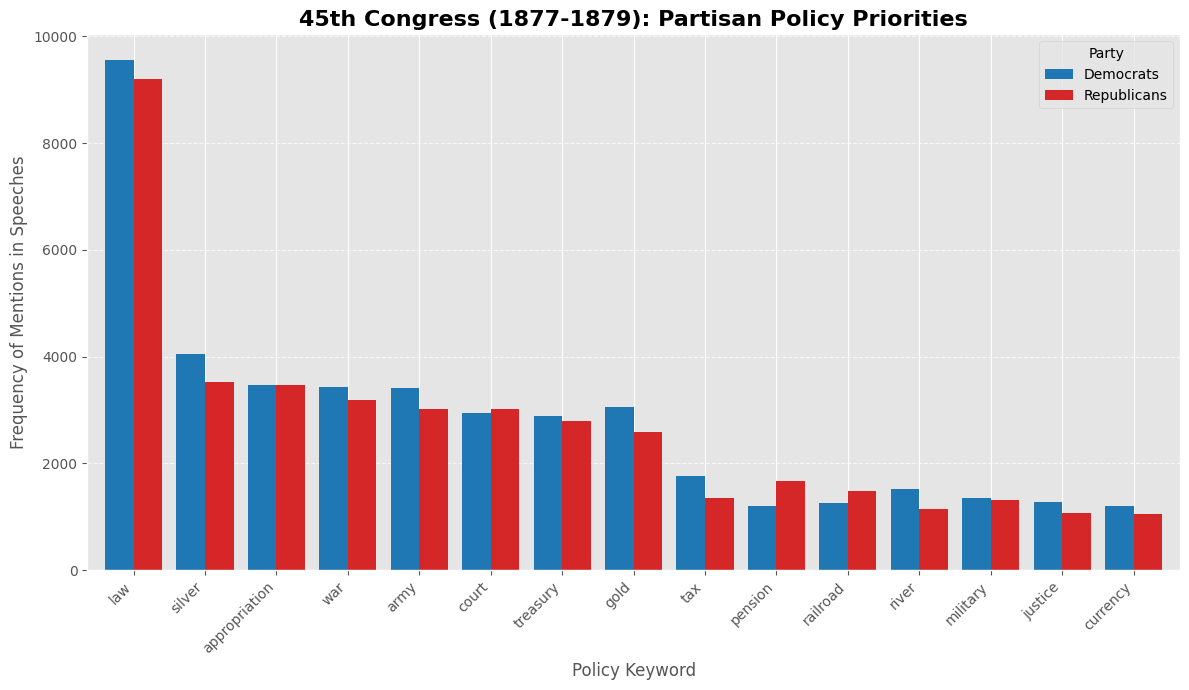

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# 1. Load your master CSV
df = pd.read_csv('/Users/mj/Desktop/Misc/VSCodeStuff/legNLP/processed/congress_045_master.csv')

# 2. Define the "Policy Signal" Vocabulary
# These are based on the 22 topics from the Stanford Codebook (Table 11)
policy_vocab = [
    'silver', 'gold', 'currency', 'coinage', 'bank', 'treasury', 'resumption',
    'army', 'military', 'war', 'pension', 'soldier', 'veteran', 'appropriation',
    'revenue', 'tax', 'deficit', 'railroad', 'bridge', 'river', 'harbor',
    'public lands', 'post office', 'court', 'justice', 'law', 'civil rights'
]

# Ensure the 'speech' column is treated as strings and fill missing values
df['speech'] = df['speech'].fillna('').astype(str)

# 3. Function to count policy mentions by party
def get_policy_counts(party_label):
    subset = df[df['party'] == party_label]['speech']
    if subset.empty:
        return pd.Series(0, index=policy_vocab)
    
    # We use CountVectorizer with a fixed vocabulary to ignore noise
    vectorizer = CountVectorizer(vocabulary=policy_vocab, stop_words='english')
    counts = vectorizer.fit_transform(subset).toarray().sum(axis=0)
    return pd.Series(counts, index=policy_vocab)

# 4. Generate the counts for each party
dem_counts = get_policy_counts('D')
rep_counts = get_policy_counts('R')

# 5. Prepare data for plotting
comparison_df = pd.DataFrame({
    'Democrats': dem_counts, 
    'Republicans': rep_counts
})

# Sort by total mentions and take the top 15 for a cleaner visual
comparison_df['Total'] = comparison_df['Democrats'] + comparison_df['Republicans']
plot_df = comparison_df.sort_values(by='Total', ascending=False).head(15).drop(columns='Total')

# 6. Create the Plot
plt.style.use('ggplot') # Optional: makes the chart look more professional
ax = plot_df.plot(
    kind='bar', 
    figsize=(12, 7), 
    color=['#1f77b4', '#d62728'], # Blue for Dem, Red for Rep
    width=0.8
)

# Customizing the chart labels
plt.title('45th Congress (1877-1879): Partisan Policy Priorities', fontsize=16, fontweight='bold')
plt.ylabel('Frequency of Mentions in Speeches', fontsize=12)
plt.xlabel('Policy Keyword', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Party")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 7. (Optional) Save for your GitHub README
# plt.savefig('partisan_priorities_chart.png', dpi=300)

--- Economic Debate Frequency per Session ---
    congress_session  mention_count
0                 45           1762
1                 46           1341
2                 47           1056
3                 48            635
4                 49           1388
5                 50            832
6                 51           3112
7                 52           1790
8                 53           5291
9                 54           2220
10                55           2391
11                56           1721
12                57           1012
13                58            556
14                59            903
15                60            632
16                61            740
17                62            622
18                63           1868
19                64            678


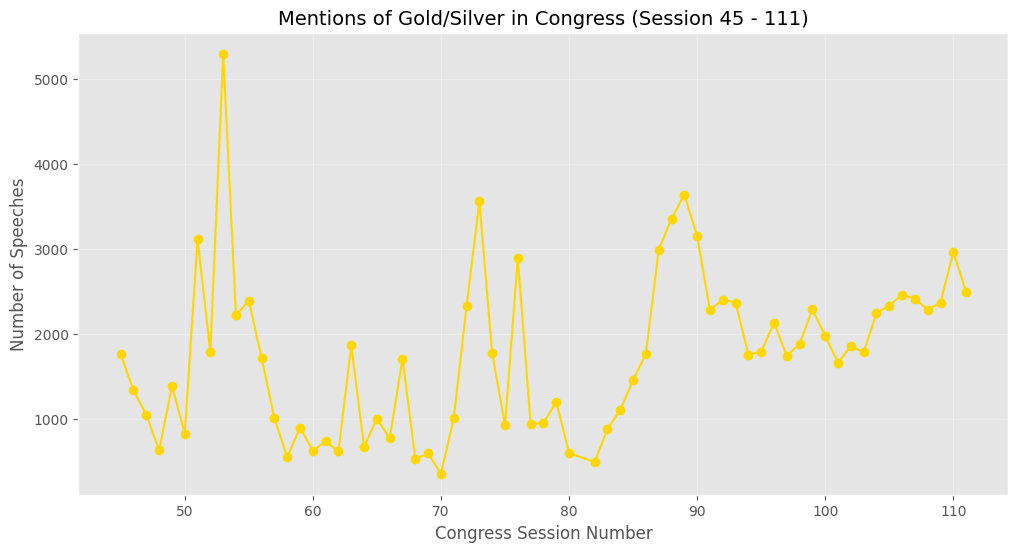

In [30]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect('congress_master.db')

# Using '%' without spaces to catch 'silver.', 'silver,', etc.
keyword_query = """
SELECT congress_session, COUNT(*) as mention_count
FROM speeches
WHERE speech LIKE '%silver%' OR speech LIKE '%gold%'
GROUP BY congress_session
ORDER BY congress_session ASC
"""

trends_df = pd.read_sql(keyword_query, conn)
conn.close()

# --- DISPLAY THE DATA ---
if not trends_df.empty:
    print("--- Economic Debate Frequency per Session ---")
    print(trends_df.head(20)) # Prints the first 20 rows

    # --- PLOT THE TREND ---
    plt.figure(figsize=(12, 6))
    plt.plot(trends_df['congress_session'], trends_df['mention_count'], marker='o', color='gold')
    plt.title('Mentions of Gold/Silver in Congress (Session 45 - 111)', fontsize=14)
    plt.xlabel('Congress Session Number')
    plt.ylabel('Number of Speeches')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No results found. Double-check if the database has been populated!")